In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## import data

In [2]:
df_o2 = pd.read_csv('../Dissertation_projects/Data/CTD/O2_Summary_Stats.csv', sep=',', index_col=0)

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

df_doc = df_doc.drop(222101, axis=0)
df_doc = df_doc.drop(212211, axis=0)

df_doc

,Treatment,Campaign,Date,Location,NPOC Conc (mg/L),TN Conc (mg/L),Depth,Notes,Type,Time,Dil Factor,NPOC_uM,TN_uM,dil_fac,NPOC_uM_std,TN_uM_std,date_time,code
Sample ID,,,,,,,,,,,,,,,,,,
211901,P2F,GOM2021,2021-07-15,St.MK,1.2220,0.1955,16.7,NaN,WC,NaN,NaN,101.833333,13.964286,NaN,2.988328,0.517500,2021-07-15,St.MK_GOM2021
211902,P2F,GOM2021,2021-07-15,St.MK,1.2235,0.182,16.7,NaN,WC,NaN,NaN,101.958333,13.000000,NaN,2.991996,0.481765,2021-07-15,St.MK_GOM2021
211903,P2F,GOM2021,2021-07-15,St.MK,1.3505,0.11485,14.0,NaN,WC,NaN,NaN,112.541667,8.203571,NaN,3.302567,0.304015,2021-07-15,St.MK_GOM2021
211904,P2F,GOM2021,2021-07-15,St.MK,1.5765,BDL,14.0,NaN,WC,NaN,NaN,131.375000,0.323571,NaN,3.855237,0.011991,2021-07-15,St.MK_GOM2021
211905,P2F,GOM2021,2021-07-15,St.MK,1.4525,0.1677,10.0,NaN,WC,NaN,NaN,121.041667,11.978571,NaN,3.552002,0.443912,2021-07-15,St.MK_GOM2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222162,P2F,GOM22SP,2022-04-18,St.13,17.2347,1.591905,0.5,NaN,RZ,NaN,5.0,1436.225000,132.658750,5.0,29.315160,3.165753,2022-04-18,St.13_GOM22SP
222164,P2F,GOM22SP,2022-04-18,St.13,34.6115,2.257505,4.5,NaN,RZ,NaN,5.0,2884.291667,188.125417,5.0,58.872023,4.489403,2022-04-18,St.13_GOM22SP
222165,P2F,GOM22SP,2022-04-18,St.13,5.1500,1.04625,6.5,NaN,RZ,NaN,5.0,429.166667,87.187500,5.0,8.759832,2.080632,2022-04-18,St.13_GOM22SP


In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [6]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [7]:
#get BC data sets 
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

## Data for flux calculations 

In [8]:
#hights data
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [9]:
#porosity data 
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [10]:
#location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')

## slope calculations

In [11]:
#figure calculate pore water 

#DOC slopes pore water 
df_doc_pw_plot = df_doc_pw[(df_doc_pw['NPOC_uM'] != 0)]
df_doc_pw_plot = df_doc_pw_plot[(df_doc_pw_plot['Depth'] >= 0)]
df_doc_pw_plot = df_doc_pw_plot.dropna(subset=["NPOC_uM"])
df_doc_pw_plot = df_doc_pw_plot.sort_values(by='code')
codes = df_doc_pw_plot['code'].unique()

print(codes)
len(codes)

['St.11_GOM2021' 'St.11_GOM21FA' 'St.11_GOM22SU' 'St.12_GOM21FA'
 'St.12_GOM22SU' 'St.13_GOM21FA' 'St.13_GOM22SP' 'St.13_GOM22SU'
 'St.14_GOM2021' 'St.14_GOM21FA' 'St.14_GOM22SP' 'St.14_GOM22SU'
 'St.15_GOM2021' 'St.15_GOM21FA' 'St.15_GOM22SP' 'St.15_GOM22SU'
 'St.16_GOM2021' 'St.16_GOM21FA' 'St.16_GOM22SP' 'St.2_GOM2021'
 'St.2_GOM21FA' 'St.2_GOM22SP' 'St.2_GOM22SU' 'St.4_GOM2021'
 'St.4_GOM21FA' 'St.4_GOM22SP' 'St.4_GOM22SU' 'St.5B_GOM2021'
 'St.5B_GOM21FA' 'St.5B_GOM22SU' 'St.7_GOM2021' 'St.7_GOM21FA'
 'St.7_GOM22SP' 'St.7_GOM22SU' 'St.9_GOM2021' 'St.9_GOM21FA'
 'St.9_GOM22SP' 'St.9_GOM22SU' 'St.MK_GOM2021' 'St.MK_GOM21FA'
 'St.MK_GOM22SP' 'St.MK_GOM22SU']


42

In [12]:
df_doc_wc_plot = df_doc_wc[df_doc_wc['code'].isin(codes)]

max_depth_per_code = df_doc_wc_plot.groupby('code')['Depth'].max().reset_index()
df_doc_wc_plot = pd.merge(df_doc_wc_plot, max_depth_per_code, on='code', suffixes=('', '_max'))
df_doc_wc_plot = df_doc_wc_plot[df_doc_wc_plot['Depth'] == df_doc_wc_plot['Depth_max']]
df_doc_wc_plot.drop(columns=['Depth_max'], inplace=True)

#mean_doc = df_doc_wc_plot.groupby('code')['NPOC_uM'].mean().reset_index()
#mean_tn = df_doc_wc_plot.groupby('code')['TN_uM'].mean().reset_index()
#std_doc = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mesuan().reset_index()
#stc_tn = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mean().reset_index()

df_doc_wc_plot['Depth_sample'] = df_doc_wc_plot['Depth']
df_doc_wc_plot['Depth'] = -0.5

# Calculate the mean of "NPOC_uM", "TN_uM", and "Depth" for each group in 'code'
df_doc_wc_plot = df_doc_wc_plot.groupby('code').agg({'NPOC_uM': 'mean', 'TN_uM': 'mean', 'Depth': 'mean', 'NPOC_uM_std': 'sum', 'TN_uM_std': 'sum'}).reset_index()


# Display the result dataframe
df_doc_wc_plot


,code,NPOC_uM,TN_uM,Depth,NPOC_uM_std,TN_uM_std
0,St.11_GOM2021,106.625000,35.994643,-0.5,1.704837,0.723733
1,St.11_GOM21FA,48.339583,28.237500,-0.5,1.027276,2.471537
2,St.11_GOM22SU,38.945833,24.207143,-0.5,0.277769,0.397060
3,St.12_GOM21FA,48.875000,28.782143,-0.5,1.038654,2.519208
4,St.12_GOM22SU,65.222917,28.582143,-0.5,0.517690,0.336783
5,St.13_GOM21FA,52.391440,29.832143,-0.5,0.639296,0.306995
6,St.13_GOM22SP,64.608333,28.153571,-0.5,0.425819,0.513220
7,St.13_GOM22SU,26.844481,52.706462,-0.5,54.817104,27.664921
8,St.14_GOM2021,70.231250,12.898214,-0.5,4.121912,0.955985
9,St.14_GOM21FA,60.520833,13.425000,-0.5,0.643071,0.587523


In [13]:
df_concatenated = pd.concat([df_doc_pw_plot, df_doc_wc_plot], ignore_index=True)
df_doc_pw_plot = df_concatenated.sort_values(by='code')
df_doc_pw_plot

,Treatment,Campaign,Date,Location,NPOC Conc (mg/L),TN Conc (mg/L),Depth,Notes,Type,Time,Dil Factor,NPOC_uM,TN_uM,dil_fac,NPOC_uM_std,TN_uM_std,date_time,code
0,P2F,GOM2021,2021-07-25,St.11,7.16250,0.5907,1.75,NaN,PW,NaN,15.0,596.875000,42.192857,15.0,11.936880,0.865354,2021-07-25,St.11_GOM2021
843,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,NaN,NaN,NaN,NaN,106.625000,35.994643,NaN,1.704837,0.723733,NaT,St.11_GOM2021
18,P2F,GOM2021,2021-07-25,St.11,16.57500,3.0705,22.20,NaN,PW,NaN,15.0,1381.250000,219.321429,15.0,27.623564,4.498172,2021-07-25,St.11_GOM2021
17,P2F,GOM2021,2021-07-25,St.11,12.51375,2.73525,24.70,NaN,PW,NaN,15.0,1042.812500,195.375000,15.0,20.855166,4.007043,2021-07-25,St.11_GOM2021
16,P2F,GOM2021,2021-07-25,St.11,14.71950,3.02925,27.70,NaN,PW,NaN,15.0,1226.625000,216.375000,15.0,24.531225,4.437742,2021-07-25,St.11_GOM2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,P2F,GOM22SU,2022-07-23,St.MK,3.32700,0.3294,0.00,NaN,PW,NaN,15.0,277.250000,23.528571,15.0,5.503549,0.481678,2022-07-23,St.MK_GOM22SU
841,P2F,GOM22SU,2022-07-23,St.MK,5.67375,1.47855,24.70,NaN,PW,NaN,15.0,472.812500,105.610714,15.0,9.385561,2.162065,2022-07-23,St.MK_GOM22SU
842,P2F,GOM22SU,2022-07-23,St.MK,8.04150,1.50285,27.70,NaN,PW,NaN,15.0,670.125000,107.346429,15.0,13.302312,2.197599,2022-07-23,St.MK_GOM22SU
829,P2F,GOM22SU,2022-07-23,St.MK,5.92275,2.18175,9.95,NaN,PW,NaN,15.0,493.562500,155.839286,15.0,9.797459,3.190346,2022-07-23,St.MK_GOM22SU


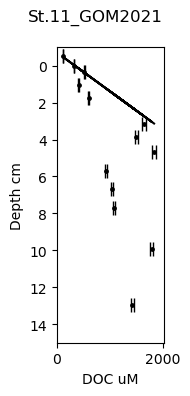

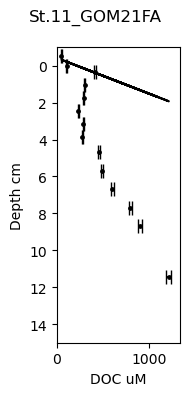

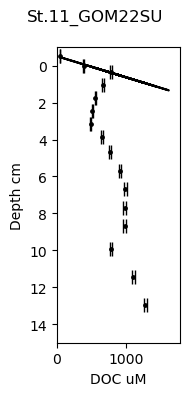

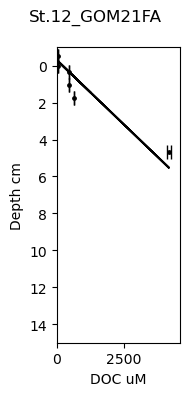

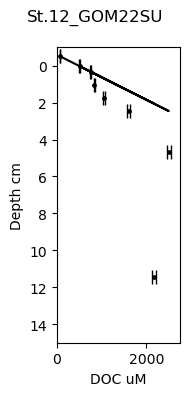

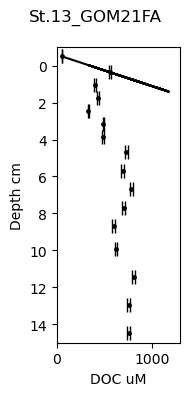

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\12763401.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


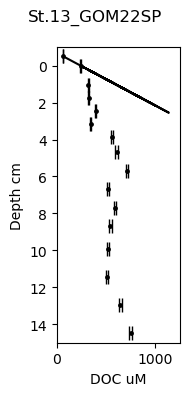

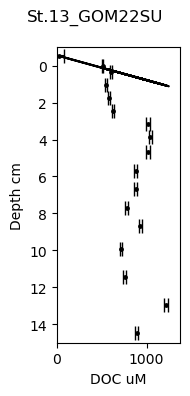

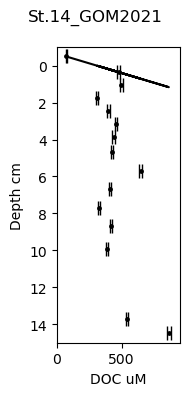

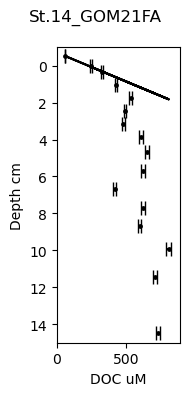

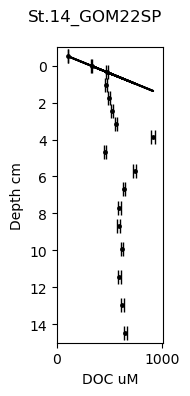

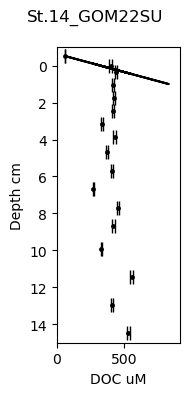

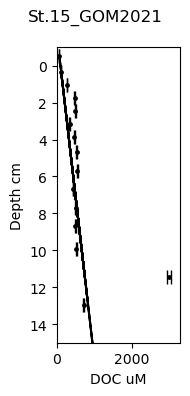

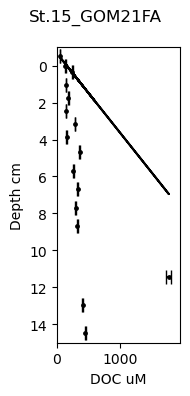

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\12763401.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


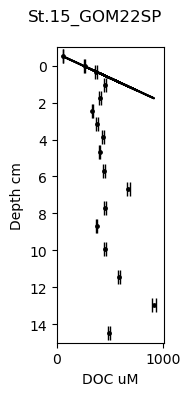

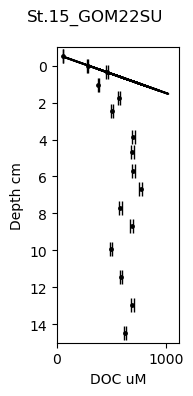

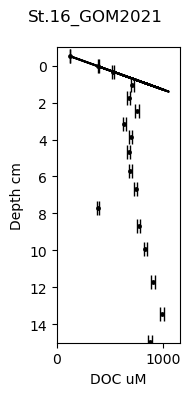

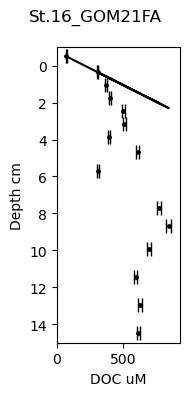

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\12763401.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


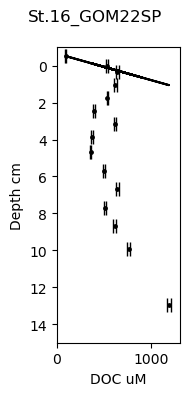

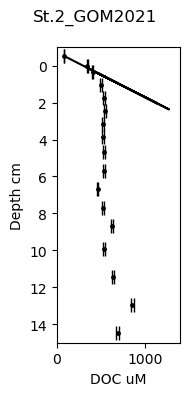

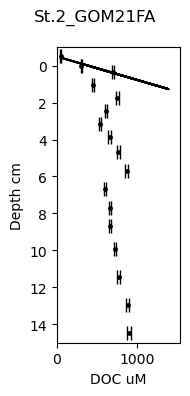

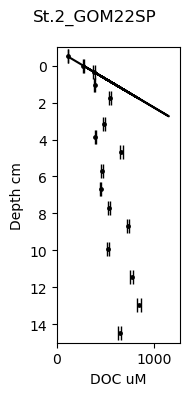

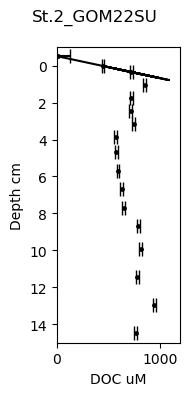

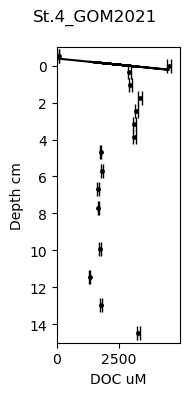

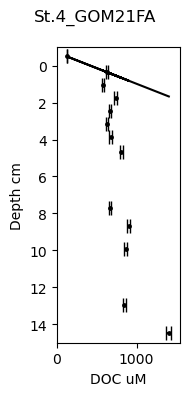

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\12763401.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


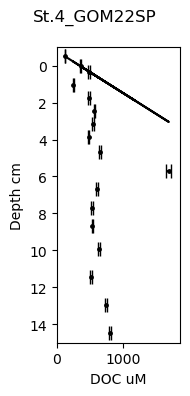

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\12763401.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


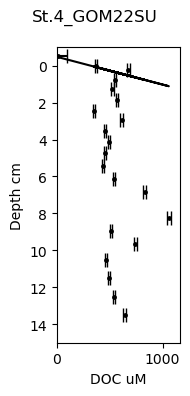

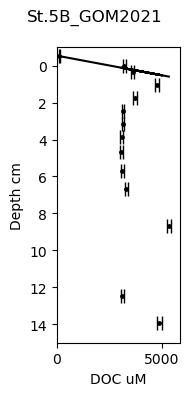

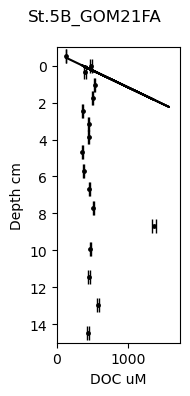

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\12763401.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


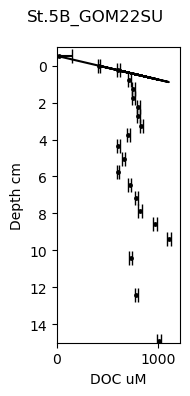

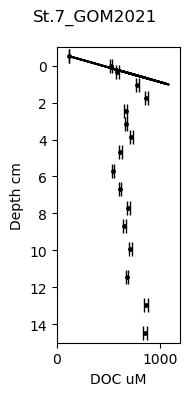

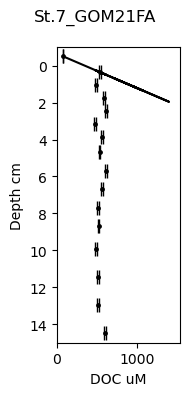

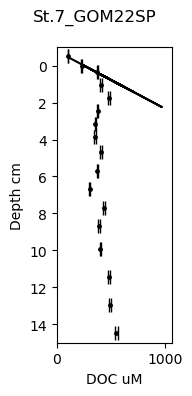

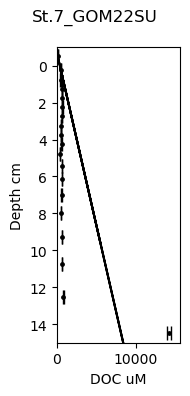

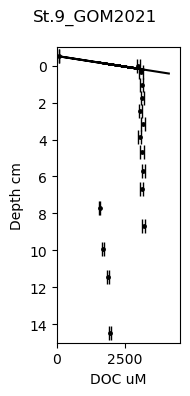

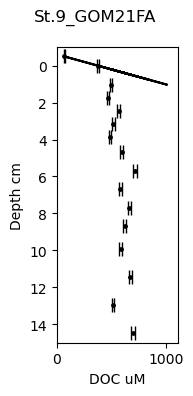

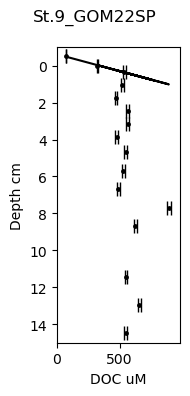

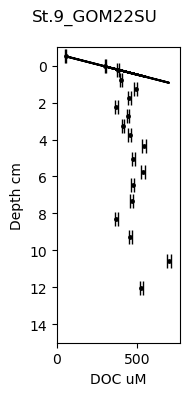

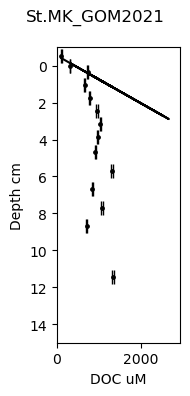

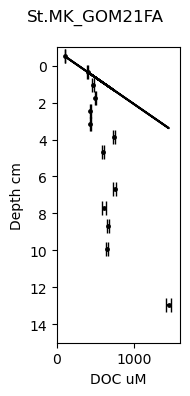

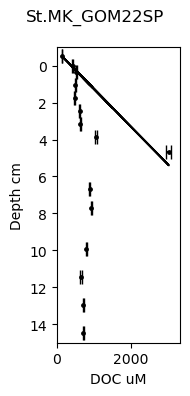

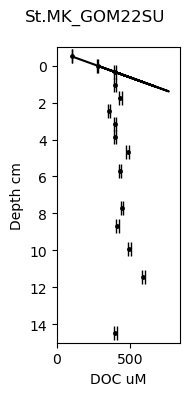

,slope_doc_pw,rsquared_doc_pw,std_err_doc_pw,flux_doc_depth_pw,por_mean,por_sd,por_count,por_SE,pw_flux_doc,pw_flux_doc_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,
St.11_GOM2021,4.757962e+05,0.994468,3.548628e+04,1.0,0.897720,0.000874,2.0,0.000618,9.595091,0.715630,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,4.080450e+05,0.786587,2.125425e+05,1.0,0.915910,0.010748,2.0,0.007600,8.395524,4.373061,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,8.560685e+05,0.981837,1.164336e+05,1.0,0.914582,0.001207,2.0,0.000853,17.588074,2.392149,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,4.321633e+05,0.603067,3.506093e+05,1.0,0.841981,0.012303,2.0,0.008700,8.174047,6.631513,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,8.176190e+05,0.996599,4.776502e+04,1.0,0.860954,0.013093,2.0,0.009258,15.813140,0.923798,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,5.877012e+05,1.000000,0.000000e+00,0.6,0.907718,0.000000,1.0,0.000000,11.983803,0.000000,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,3.533263e+05,1.000000,0.000000e+00,0.6,0.850000,0.000000,0.0,0.000000,6.746555,0.000000,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,6.922979e+05,0.927216,1.939631e+05,1.0,0.900173,0.000000,1.0,0.000000,13.999296,3.922223,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,4.772899e+05,1.000000,0.000000e+00,0.6,0.877636,0.000000,1.0,0.000000,9.409872,0.000000,28.726863,-89.601437,St.14,GOM2021


In [14]:
Frames = []

def doc_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_doc_pw_plot.loc[df_doc_pw_plot['code'] == codes[code]]
    y = sub['Depth']
    x = sub['NPOC_uM']
    er = sub['NPOC_uM_std']
    axs.scatter(x, y, c="black", s = 6)
    axs.errorbar(x, y, xerr=er, fmt='none', ecolor='black', capsize=5)
    yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() 
    xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('DOC uM')
    axs.set_ylabel('Depth cm')
    axs.set_ylim(15,-1)
    axs.set_xlim(df_doc_pw['NPOC_uM'].min(),sub['NPOC_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='black')        
        
        xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() / 1000
        yy2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

    dic = {'code':[codes[code]],
           'slope_doc_pw':[slope],
           'rsquared_doc_pw':[rsquared], 
           'std_err_doc_pw':[std_err], 
           'flux_doc_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/flux_profiles/doc_{codes[code]}.png')
    plt.show()
    
dep_1_3 = .6
dep_1_4 = 1
dep_1 = 1.5
dep_2 = -1


doc_flux_cal(0, dep_1_4, dep_2)
doc_flux_cal(1, dep_1_4, dep_2)
doc_flux_cal(2, dep_1_4, dep_2)
doc_flux_cal(3, dep_1_4, dep_2)
doc_flux_cal(4, dep_1_4, dep_2)
doc_flux_cal(5, dep_1_3, dep_2)
doc_flux_cal(6, dep_1_3, dep_2)
doc_flux_cal(7, dep_1_4, dep_2)
doc_flux_cal(8, dep_1_3, dep_2)
doc_flux_cal(9, dep_1_4, dep_2)
doc_flux_cal(10, dep_1_4, dep_2)
doc_flux_cal(11, dep_1_4, dep_2)
doc_flux_cal(12, dep_1_3, dep_2)
doc_flux_cal(13, dep_1_3, dep_2)
doc_flux_cal(14, dep_1_3, dep_2)
doc_flux_cal(15, dep_1_3, dep_2)
doc_flux_cal(16, dep_1_3, dep_2)
doc_flux_cal(17, dep_1_3, dep_2)
doc_flux_cal(18, dep_1_3, dep_2)
doc_flux_cal(19, dep_1_3, dep_2)
doc_flux_cal(20, dep_1_4, dep_2)
doc_flux_cal(21, dep_1_3, dep_2)
doc_flux_cal(22, dep_1_3, dep_2)
doc_flux_cal(23, dep_1_4, dep_2)
doc_flux_cal(24, dep_1_4, dep_2)
doc_flux_cal(25, dep_1_3, dep_2)
doc_flux_cal(26, dep_1_4, dep_2)
doc_flux_cal(27, dep_1_4, dep_2)
doc_flux_cal(28, dep_1_4, dep_2)
doc_flux_cal(29, dep_1_3, dep_2)
doc_flux_cal(30, dep_1_4, dep_2)
doc_flux_cal(31, dep_1_3, dep_2)
doc_flux_cal(32, dep_1_4, dep_2)
doc_flux_cal(33, dep_1_3, dep_2)
doc_flux_cal(34, dep_1_3, dep_2)
doc_flux_cal(35, dep_1_3, dep_2)
doc_flux_cal(36, dep_1_3, dep_2)
doc_flux_cal(37, dep_1_3, dep_2)
doc_flux_cal(38, dep_1_4, dep_2)
doc_flux_cal(39, dep_1_3, dep_2)
doc_flux_cal(40, dep_1_3, dep_2)
doc_flux_cal(41, dep_1_3, dep_2)


slopes_doc_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_doc_pw['por_mean'].fillna(0.85, inplace=True)
slopes_doc_pw['por_sd'].fillna(0, inplace=True)
slopes_doc_pw['por_SE'] = slopes_doc_pw['por_sd'] / (np.sqrt(slopes_doc_pw['por_count']))
slopes_doc_pw['por_SE'].fillna(0, inplace=True)

D_doc = 2.6 * (10**-6) / 10000 * (86400) #0.000001728 

#slopes_doc_pw["pw_flux_doc"] = slopes_doc_pw["slope_doc_pw"] * (slopes_doc_pw["flux_doc_depth_pw"] * A * slopes_doc_pw["por_mean"] ) * D_doc
slopes_doc_pw["pw_flux_doc"] = slopes_doc_pw["slope_doc_pw"] * (slopes_doc_pw["por_mean"] ) * D_doc 
slopes_doc_pw["pw_flux_doc_error"] = slopes_doc_pw["std_err_doc_pw"] * slopes_doc_pw["por_mean"] * D_doc 

slopes_doc_pw = pd.concat([slopes_doc_pw, df_lat_lon], axis=1, join='outer')
slopes_doc_pw['Stn'] = slopes_doc_pw.index.str.split('_').str[0]
slopes_doc_pw['Camp'] = slopes_doc_pw.index.str.split('_').str[1]
slopes_doc_pw = slopes_doc_pw.dropna(subset=['pw_flux_doc'])

slopes_doc_pw 

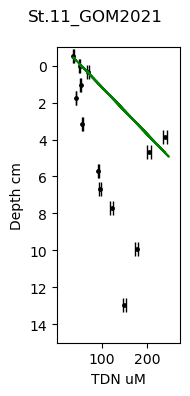

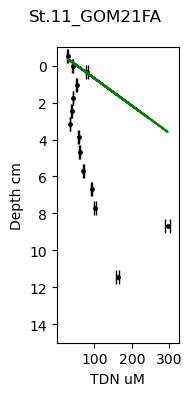

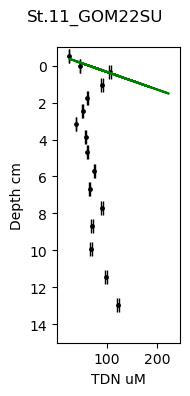

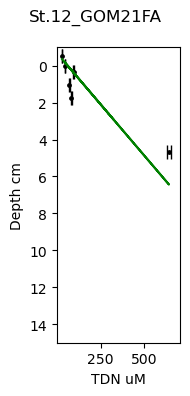

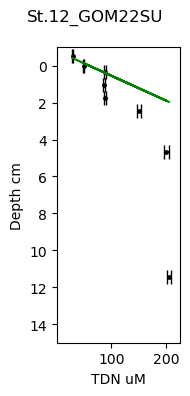

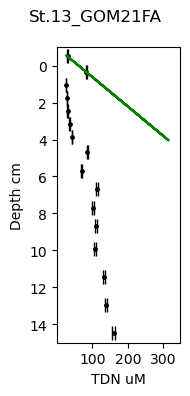

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\2251273297.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


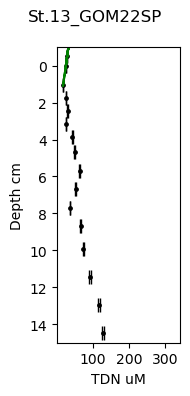

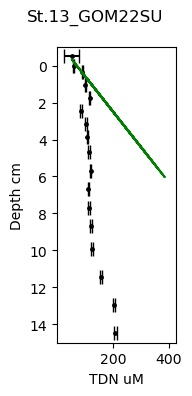

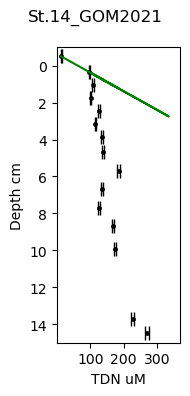

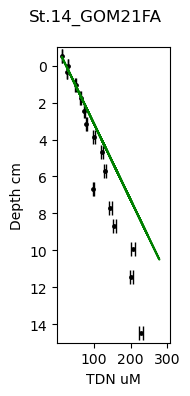

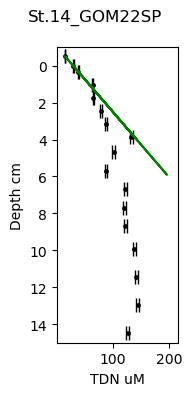

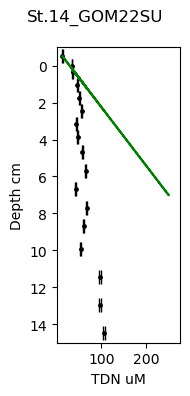

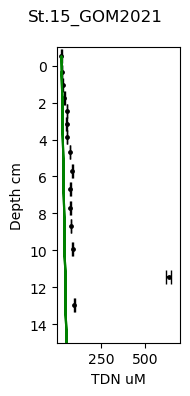

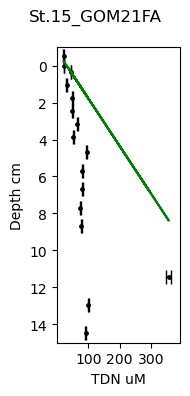

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\2251273297.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


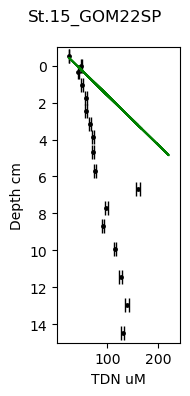

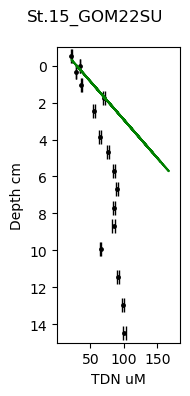

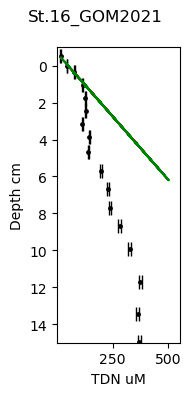

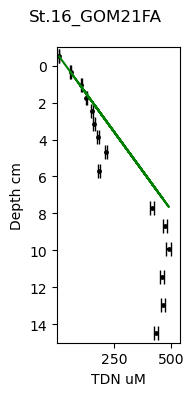

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\2251273297.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


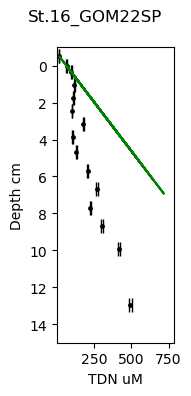

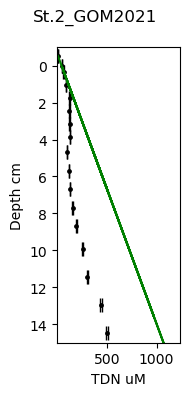

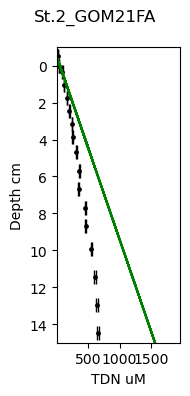

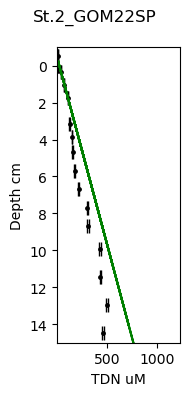

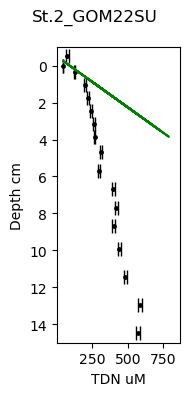

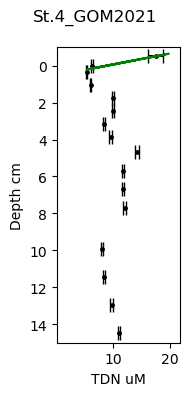

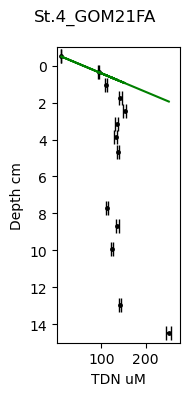

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\2251273297.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


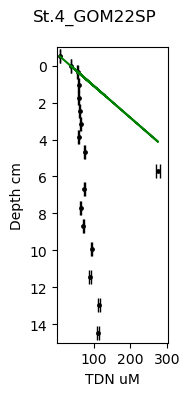

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\2251273297.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


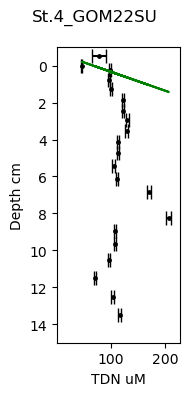

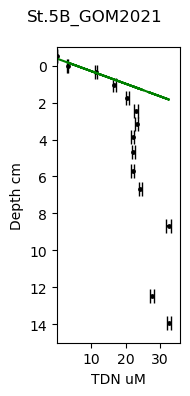

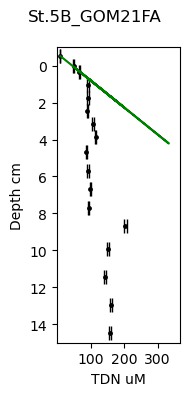

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_25816\2251273297.py:35: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


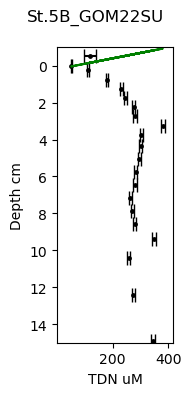

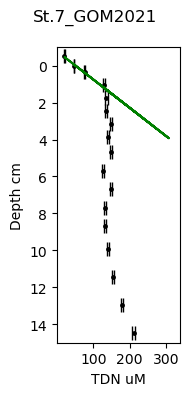

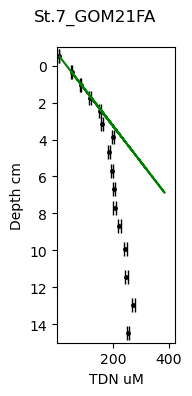

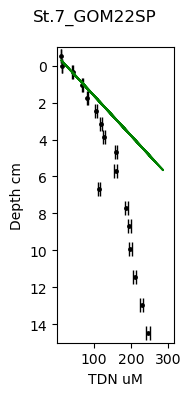

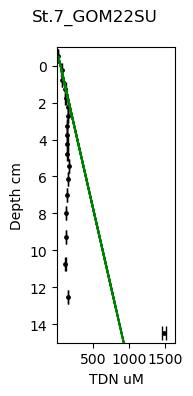

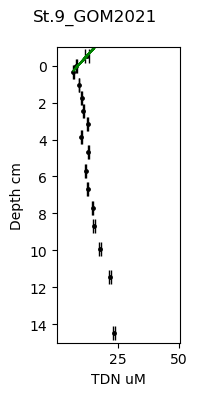

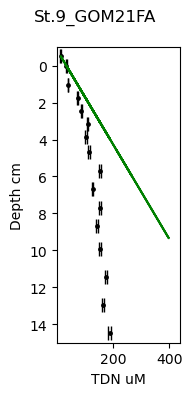

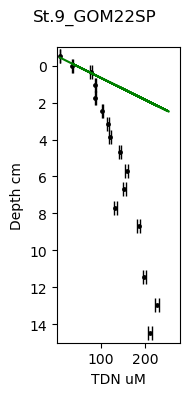

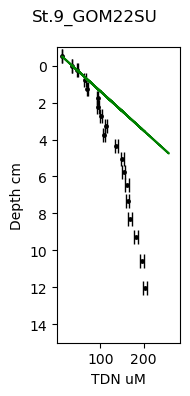

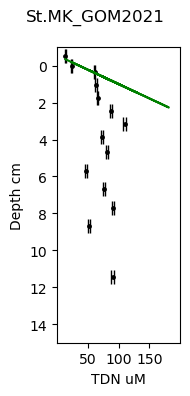

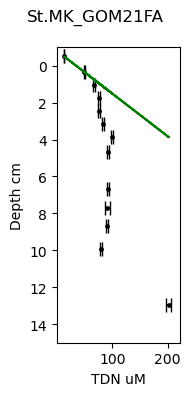

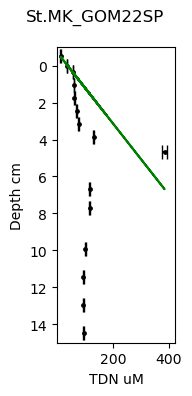

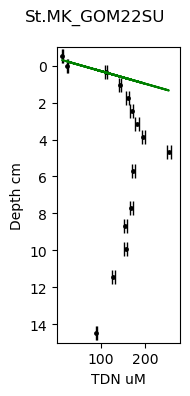

,slope_tn_pw,rsquared_tn_pw,std_err_tn_pw,flux_tn_depth_pw,por_mean,por_sd,por_count,por_SE,pw_flux_tn,pw_flux_tn_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,
St.11_GOM2021,38117.172218,0.966299,7118.440713,1.0,0.897720,0.000874,2.0,0.000618,1.478242,0.276064,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,59057.201090,0.874585,22363.828067,1.0,0.915910,0.010748,2.0,0.007600,2.336734,0.884876,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,91808.952999,0.872908,35031.518451,1.0,0.914582,0.001207,2.0,0.000853,3.627367,1.384093,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,76455.226849,0.845349,32701.320554,1.0,0.841981,0.012303,2.0,0.008700,2.780949,1.189464,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,68627.201566,0.919699,20278.439591,1.0,0.860954,0.013093,2.0,0.009258,2.552467,0.754221,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,62794.117647,1.000000,0.000000,0.6,0.907718,0.000000,1.0,0.000000,2.462372,0.000000,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,-7138.457260,1.000000,0.000000,0.6,0.850000,0.000000,0.0,0.000000,-0.262124,0.000000,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,42927.698751,0.822602,19935.013670,1.0,0.900173,0.000000,1.0,0.000000,1.669350,0.775223,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,99113.653218,1.000000,0.000000,0.6,0.877636,0.000000,1.0,0.000000,3.757783,0.000000,28.726863,-89.601437,St.14,GOM2021


In [15]:
Frames = []

def doc_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_doc_pw_plot.loc[df_doc_pw_plot['code'] == codes[code]]
    y = sub['Depth']
    x = sub['TN_uM']
    er = sub['TN_uM_std']
    axs.scatter(x, y, c="black", s = 6)
    axs.errorbar(x, y, xerr=er, fmt='none', ecolor='black', capsize=5)
    yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() 
    xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('TDN uM')
    axs.set_ylabel('Depth cm')
    axs.set_ylim(15,-1)
    axs.set_xlim(df_doc_pw['TN_uM'].min(),sub['TN_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='green')        
        
        xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() / 1000
        yy2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

    dic = {'code':[codes[code]],
           'slope_tn_pw':[slope],
           'rsquared_tn_pw':[rsquared], 
           'std_err_tn_pw':[std_err], 
           'flux_tn_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/flux_profiles/tdn_{codes[code]}.png')
    plt.show()
    
dep_1_3 = .6
dep_1_4 = 1
dep_1 = 1.5
dep_2 = -1


doc_flux_cal(0, dep_1_4, dep_2)
doc_flux_cal(1, dep_1_4, dep_2)
doc_flux_cal(2, dep_1_4, dep_2)
doc_flux_cal(3, dep_1_4, dep_2)
doc_flux_cal(4, dep_1_4, dep_2)
doc_flux_cal(5, dep_1_3, dep_2)
doc_flux_cal(6, dep_1_3, dep_2)
doc_flux_cal(7, dep_1_4, dep_2)
doc_flux_cal(8, dep_1_3, dep_2)
doc_flux_cal(9, dep_1_4, dep_2)
doc_flux_cal(10, dep_1_4, dep_2)
doc_flux_cal(11, dep_1_4, dep_2)
doc_flux_cal(12, dep_1_3, dep_2)
doc_flux_cal(13, dep_1_3, dep_2)
doc_flux_cal(14, dep_1_3, dep_2)
doc_flux_cal(15, dep_1_3, dep_2)
doc_flux_cal(16, dep_1_3, dep_2)
doc_flux_cal(17, dep_1_3, dep_2)
doc_flux_cal(18, dep_1_3, dep_2)
doc_flux_cal(19, dep_1_3, dep_2)
doc_flux_cal(20, dep_1_4, dep_2)
doc_flux_cal(21, dep_1_3, dep_2)
doc_flux_cal(22, dep_1_3, dep_2)
doc_flux_cal(23, dep_1_4, dep_2)
doc_flux_cal(24, dep_1_4, dep_2)
doc_flux_cal(25, dep_1_3, dep_2)
doc_flux_cal(26, dep_1_4, dep_2)
doc_flux_cal(27, dep_1_4, dep_2)
doc_flux_cal(28, dep_1_4, dep_2)
doc_flux_cal(29, dep_1_3, dep_2)
doc_flux_cal(30, dep_1_4, dep_2)
doc_flux_cal(31, dep_1_3, dep_2)
doc_flux_cal(32, dep_1_4, dep_2)
doc_flux_cal(33, dep_1_3, dep_2)
doc_flux_cal(34, dep_1_3, dep_2)
doc_flux_cal(35, dep_1_3, dep_2)
doc_flux_cal(36, dep_1_3, dep_2)
doc_flux_cal(37, dep_1_3, dep_2)
doc_flux_cal(38, dep_1_4, dep_2)
doc_flux_cal(39, dep_1_3, dep_2)
doc_flux_cal(40, dep_1_3, dep_2)
doc_flux_cal(41, dep_1_3, dep_2)

slopes_tn_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_tn_pw['por_mean'].fillna(0.85, inplace=True)
slopes_tn_pw['por_sd'].fillna(0, inplace=True)
slopes_tn_pw['por_SE'] = slopes_doc_pw['por_sd'] / (np.sqrt(slopes_doc_pw['por_count']))
slopes_tn_pw['por_SE'].fillna(0, inplace=True)

D_tn = 5 * (10**-6) / 10000 * (86400)

slopes_tn_pw["pw_flux_tn"] = slopes_tn_pw["slope_tn_pw"] * slopes_tn_pw["por_mean"] * D_tn 
slopes_tn_pw["pw_flux_tn_error"] = slopes_tn_pw["std_err_tn_pw"] * slopes_tn_pw["por_mean"] * D_tn 

slopes_tn_pw = pd.concat([slopes_tn_pw, df_lat_lon], axis=1, join='outer')
slopes_tn_pw['Stn'] = slopes_tn_pw.index.str.split('_').str[0]
slopes_tn_pw['Camp'] = slopes_tn_pw.index.str.split('_').str[1]
slopes_tn_pw = slopes_tn_pw.dropna(subset=['pw_flux_tn'])

slopes_tn_pw 

## Benthic Chamber

#figure calculate Benthic chamber 

# Drop the rows where 'dil_fac' is greater than 6
df_doc_bc = df_doc_bc[df_doc_bc['dil_fac'] <= 2]

#DOC slopes 
df_doc_bc_plot = df_doc_bc[(df_doc_bc['NPOC_uM'] != 0)]
df_doc_bc_plot = df_doc_bc_plot.dropna(subset=["NPOC_uM"])
df_doc_bc_plot = df_doc_bc_plot[df_doc_bc_plot['code'] != 'St.13_GOM22SP']
codes = df_doc_bc_plot['code'].unique()

print(codes)

Frames = []

def doc_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_doc_bc_plot.loc[df_doc_bc_plot['code'] == codes[code]]
    x = sub['Time']
    y = sub['NPOC_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'Time'].ravel()
    yy = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'NPOC_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='black')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_doc_bc':[slope],
               'rsquared_doc_bc':[rsquared], 
               'std_err_doc_bc':[std_err], 
               'flux_time_doc_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('DOC uM')
    axs.set_xlim(0,df_doc_bc['Time'].max())
    axs.set_ylim(df_doc_bc['NPOC_uM'].min(),max(y)*1.1)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
doc_flux_cal(0, 12, 0)
doc_flux_cal(1, 12, 0)
doc_flux_cal(2, 4, 0)
doc_flux_cal(3, 6, 0)
doc_flux_cal(4, 8, 0)
doc_flux_cal(5, 10, .5)
doc_flux_cal(6, 12, 0)
doc_flux_cal(7, 12, 0)
doc_flux_cal(8, 10, 0)
doc_flux_cal(9, 6, .5)
doc_flux_cal(10, 7, .5)
doc_flux_cal(11, 7, 0)
doc_flux_cal(12, 4, .5)
doc_flux_cal(13, 5, 0)
doc_flux_cal(14, 10, 0)
doc_flux_cal(15, 6, 0)
doc_flux_cal(16, 12, 0)
doc_flux_cal(17, 4, 0)
doc_flux_cal(18, 3, 0)
doc_flux_cal(19, 3, 0)
doc_flux_cal(20, 7, 0)
doc_flux_cal(21, 12, 3)
doc_flux_cal(22, 7, 3)
doc_flux_cal(23, 8, 0)
doc_flux_cal(24, 11, 0)
doc_flux_cal(25, 7, 0)
doc_flux_cal(26, 10, 0)
doc_flux_cal(27, 8, 0)
doc_flux_cal(28, 8, 0)

slopes_doc_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_doc_bc = pd.concat([slopes_doc_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_doc_bc = slopes_doc_bc.dropna(subset=['slope_doc_bc'])

slopes_doc_bc["bc_flux_doc"] = slopes_doc_bc["slope_doc_bc"] * slopes_doc_bc["Hight_m"]* 24 
slopes_doc_bc["bc_flux_doc_error"] = slopes_doc_bc["std_err_doc_bc"] * slopes_doc_bc["Hight_m"]* 24

slopes_doc_bc 

#figure calculate Benthic chamber 

#Nitrogen slops
df_tn_bc_plot = df_doc_bc[(df_doc_bc['TN_uM'] != 0)]
df_tn_bc_plot = df_tn_bc_plot.dropna(subset=["TN_uM"])
df_tn_bc_plot = df_tn_bc_plot[df_tn_bc_plot['code'] != 'St.13_GOM22SP']
codes = df_tn_bc_plot['code'].unique()

print(codes)
len(codes)

Frames = []

def tn_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_tn_bc_plot.loc[df_tn_bc_plot['code'] == codes[code]]
    x = sub['Time']
    y = sub['TN_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'Time'].ravel()
    yy = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'TN_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='g')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_tn_bc':[slope],
               'rsquared_tn_bc':[rsquared], 
               'std_err_tn_bc':[std_err], 
               'flux_time_tn_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('TN uM')
    axs.set_xlim(0,df_doc_bc['Time'].max())
    axs.set_ylim(df_doc_bc['TN_uM'].min(),max(y)*1.1)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
tn_flux_cal(0, 12, 0)
tn_flux_cal(1, 12, .5)
tn_flux_cal(2, 6, 1.5)
tn_flux_cal(3, 5, 0)
tn_flux_cal(4, 8, 0)
tn_flux_cal(5, 10, .5)
tn_flux_cal(6, 12, 3)
tn_flux_cal(7, 12, 0)
tn_flux_cal(8, 10, 0)
tn_flux_cal(9, 6, .5)
tn_flux_cal(10, 7, 1.5)
tn_flux_cal(11, 10, 0)
tn_flux_cal(12, 4, .5)
tn_flux_cal(13, 5, 0)
tn_flux_cal(14, 9, 0)
tn_flux_cal(15, 6, 0)
tn_flux_cal(16, 3, 0)
tn_flux_cal(17, 4, 0)
tn_flux_cal(18, 3, 0)
tn_flux_cal(19, 3, 0)
tn_flux_cal(20, 7, 0)
tn_flux_cal(21, 3, 0)
tn_flux_cal(22, 7, 3)
tn_flux_cal(23, 8, 0)
tn_flux_cal(24, 7, 0)
tn_flux_cal(25, 10, 0)
tn_flux_cal(26, 10, 0)
tn_flux_cal(27, 8, 0)
tn_flux_cal(28, 8, 1)

slopes_tn_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_tn_bc = pd.concat([slopes_tn_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_tn_bc = slopes_tn_bc.dropna(subset=['slope_tn_bc'])

slopes_tn_bc["bc_flux_tn"] = slopes_tn_bc['slope_tn_bc'] * slopes_tn_bc["Hight_m"] *24 
slopes_tn_bc["bc_flux_tn_error"] = slopes_tn_bc["std_err_tn_bc"] * slopes_tn_bc["Hight_m"]* 24

slopes_tn_bc 

slopes_doc_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_doc_bc.csv')
slopes_doc_bc

slopes_tn_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_tn_bc.csv')
slopes_tn_bc

In [16]:
slopes_doc_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_doc_pw.csv')
slopes_doc_pw

,slope_doc_pw,rsquared_doc_pw,std_err_doc_pw,flux_doc_depth_pw,por_mean,por_sd,por_count,por_SE,pw_flux_doc,pw_flux_doc_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,
St.11_GOM2021,4.757962e+05,0.994468,3.548628e+04,1.0,0.897720,0.000874,2.0,0.000618,9.595091,0.715630,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,4.080450e+05,0.786587,2.125425e+05,1.0,0.915910,0.010748,2.0,0.007600,8.395524,4.373061,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,8.560685e+05,0.981837,1.164336e+05,1.0,0.914582,0.001207,2.0,0.000853,17.588074,2.392149,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,4.321633e+05,0.603067,3.506093e+05,1.0,0.841981,0.012303,2.0,0.008700,8.174047,6.631513,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,8.176190e+05,0.996599,4.776502e+04,1.0,0.860954,0.013093,2.0,0.009258,15.813140,0.923798,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,5.877012e+05,1.000000,0.000000e+00,0.6,0.907718,0.000000,1.0,0.000000,11.983803,0.000000,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,3.533263e+05,1.000000,0.000000e+00,0.6,0.850000,0.000000,0.0,0.000000,6.746555,0.000000,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,6.922979e+05,0.927216,1.939631e+05,1.0,0.900173,0.000000,1.0,0.000000,13.999296,3.922223,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,4.772899e+05,1.000000,0.000000e+00,0.6,0.877636,0.000000,1.0,0.000000,9.409872,0.000000,28.726863,-89.601437,St.14,GOM2021


In [17]:
slopes_tn_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_tn_pw.csv')
slopes_tn_pw

,slope_tn_pw,rsquared_tn_pw,std_err_tn_pw,flux_tn_depth_pw,por_mean,por_sd,por_count,por_SE,pw_flux_tn,pw_flux_tn_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,
St.11_GOM2021,38117.172218,0.966299,7118.440713,1.0,0.897720,0.000874,2.0,0.000618,1.478242,0.276064,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,59057.201090,0.874585,22363.828067,1.0,0.915910,0.010748,2.0,0.007600,2.336734,0.884876,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,91808.952999,0.872908,35031.518451,1.0,0.914582,0.001207,2.0,0.000853,3.627367,1.384093,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,76455.226849,0.845349,32701.320554,1.0,0.841981,0.012303,2.0,0.008700,2.780949,1.189464,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,68627.201566,0.919699,20278.439591,1.0,0.860954,0.013093,2.0,0.009258,2.552467,0.754221,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,62794.117647,1.000000,0.000000,0.6,0.907718,0.000000,1.0,0.000000,2.462372,0.000000,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,-7138.457260,1.000000,0.000000,0.6,0.850000,0.000000,0.0,0.000000,-0.262124,0.000000,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,42927.698751,0.822602,19935.013670,1.0,0.900173,0.000000,1.0,0.000000,1.669350,0.775223,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,99113.653218,1.000000,0.000000,0.6,0.877636,0.000000,1.0,0.000000,3.757783,0.000000,28.726863,-89.601437,St.14,GOM2021
